# Factor Investing for fixed-income

### S. Balan, J.P. Maltais


## Importing Libraries and installing Eikon

In [1]:
import eikon as ek  # the Eikon Python wrapper package
import numpy as np  # NumPy
import pandas as pd  # pandas
import cufflinks as cf  # Cufflinks
import configparser as cp
import matplotlib.pyplot as mlp
import numpy as np
import statsmodels.api as sm

In [6]:
cfg = cp.ConfigParser()
cfg.read('eikon.cfg')  # adjust for different file location

['eikon.cfg']

In [8]:
ek.set_app_key(cfg['eikon']['app_id'])

## Computing returns on 2Y Euro Benchmark

In [24]:

## Retrieve dataframe of stated Bund benchmark
df, e = ek.get_data('EU2YT=RR', ['TR.MIDPRICE', 'TR.MIDPRICE.date', 'TR.FiFirstCouponDate',   
                                     'TR.ASKPRICE', 'TR.BIDPRICE']
                    , {'SDate':'2021-04-01','EDate':'2023-5-25','Frq':'D'})

df = df.reset_index(drop=True)

#Retrieving Coupon rate
coupon_df, e = ek.get_data('EU2YT=RR', ['TR.ADF_COUPON']
                    , {'SDate':'2021-01-01','EDate':'2023-5-25','Frq':'M'})
yearly_coupon = coupon_df['Coupon'].iloc[0]

##COMPUTATIONS BEGIN HERE


#Applied Accrued interest based on coupon rate/365 days
df['AccInterest'] = (yearly_coupon)/365
df['AccInterest'].iloc[0] = 0

#Accrued interest cummulated every day, day over day
df['AccInterest'] = df['AccInterest'].cumsum()

#Total value of a bond at day t = Mid Price at day t + all coupon (day basis) accrued until day t
df['Total value'] = df['Mid Price'] + df['AccInterest']  ##UNSURE!!!


# Return = Midprice at time t - Midprice at time t-30 + daily coupon accured until time t - till time t-30
time_param = 30 #days
df['Return'] = df['Mid Price'] - df['Mid Price'].shift(time_param) + (df['AccInterest'] - df['AccInterest'].shift(time_param))


bund_ttr = df['Return']

TTR of bund on day to day basis. We will fill NaN values later on

In [25]:
bund_ttr

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
556   -0.195521
557   -0.290521
558   -0.025521
559    0.068479
560   -0.043521
Name: Return, Length: 561, dtype: float64

## Retrivieving monthly returns

let's look at generating monthly returns of Intl Cons. Airlines Group

In [26]:
#Retrieve data from Refintiv 

df, e = ek.get_data('ES232242345=', ['TR.MIDPRICE', 'TR.MIDPRICE.date', 'TR.FiFirstCouponDate', 'TR.ZSPREAD', 
                                     'TR.FIWorstCorpModDuration', 'TR.FiOptionAdjustedSpreadDuration',
                                     'TR.ASKPRICE', 'TR.BIDPRICE', 'TR.MODIFIEDDURATION',
                                    'TR.BENCHMARKSPREAD', 'TR.OPTIONADJUSTEDSPREADBID']
                    , {'SDate':'2021-04-01','EDate':'2023-5-25','Frq':'D'})


## We then convert the date strings to datetime format
df['First Coupon Date'] = pd.to_datetime(df['First Coupon Date'], utc=True)
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['First Coupon Date'] = df['First Coupon Date'].fillna(df['First Coupon Date'].iloc[0])
df['Worst Corp Mod Duration'] = df['Worst Corp Mod Duration'].fillna(df['Worst Corp Mod Duration'].iloc[0])


### This is just dressing, doesn't change the result except make the DF a bit more detailed
### for brevity. 

# Change the First coupon date column to 'Next coupon date'. We apply the function multiple times to reflect each coupon accrued date
df.loc[df['Date'] > df['First Coupon Date'], 'First Coupon Date'] = df['First Coupon Date'] + pd.offsets.DateOffset(years=1)
df.loc[df['Date'] > df['First Coupon Date'], 'First Coupon Date'] = df['First Coupon Date'] + pd.offsets.DateOffset(years=1)
df.loc[df['Date'] > df['First Coupon Date'], 'First Coupon Date'] = df['First Coupon Date'] + pd.offsets.DateOffset(years=1)
df = df.rename(columns={'First Coupon Date': 'NextCouponDate'})
df = df.reset_index(drop=True)

#Retrieving Coupon rate
coupon_df, e = ek.get_data('ES232242345=', ['TR.ADF_COUPON']
                    , {'SDate':'2021-01-01','EDate':'2023-5-25','Frq':'M'})
coupon = coupon_df['Coupon'].iloc[0]








### Coupon Rate calculations

In [27]:
#Applied Accrued interest based on coupon rate/365 days
df['AccInterest'] = (coupon)/365

##Accrued interest on day 1 is 0. 
df['AccInterest'].iloc[0] = 0

#Accrued interest cummulated every day, day over day
df['AccInterest'] = df['AccInterest'].cumsum()

#Total value of a bond at day t = Mid Price at day t + all coupon (day basis) accrued until day t
df['Total value'] = df['Mid Price'] + df['AccInterest']  ##UNSURE!!!




### Returns calculations

In [28]:
time_param = 30 #days

# Return = Midprice at time t - Midprice at time t-30 + daily coupon accured until time t - till time t-30
df['Return'] = df['Mid Price'] - df['Mid Price'].shift(time_param) + (df['AccInterest'] - df['AccInterest'].shift(time_param))
##UNSURE!!!
## This also means the Return fields stay empty for the first 30 days. 


# True excess return compared to bund
df['TrueReturn'] = df['Return'] - bund_ttr


### DTS and LTS

Modified Duration is given by Refinitiv and is used as is:

In [29]:
#Computing DTS. Paper mentions two ways. Claims DTS can be Option adjusted spread bid, or spread * some duration
df['DTS'] = df['Z Spread']*df['Worst Corp Mod Duration']
df['DTS'] = df['Option Adjusted Spread Bid']


#LTS
#df['LTS'] = df['Mid Price'] * ((df['Ask Price'].shift(time_param) - df['Bid Price'].shift(time_param) ) -  (df['Ask Price'] - df['Bid Price']) )
df['LTS'] = df['Ask Price'] - df['Bid Price']


## Data Preview

Filling all NaN values

In [30]:
df = df.fillna(0)
df[['Return', 'Modified Duration','LTS', 'DTS']]

,Return,Modified Duration,LTS,DTS
0,0.000000,3.697,0.551,342.37
1,0.000000,3.697,0.551,342.07
2,0.000000,3.697,0.551,341.85
3,0.000000,3.702,0.555,321.75
4,0.000000,3.699,0.555,324.32
...,...,...,...,...
556,1.042027,1.727,0.334,136.19
557,0.871027,1.725,0.333,135.77
558,1.120027,1.724,0.334,121.01
559,0.899027,1.720,0.333,130.89


## Plotting performance and relative performance

<AxesSubplot:>

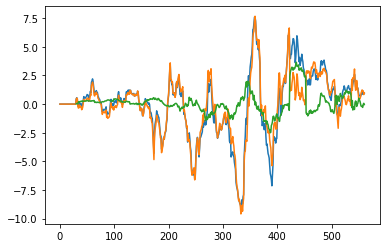

In [31]:
df['Return'].plot() #TTR of bond  in BLUE
df['TrueReturn'].plot() #TTR of bond - TTR of benchmark  in YELLOW
bund_ttr.plot() # in GREEN

<AxesSubplot:>

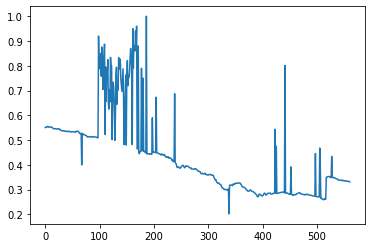

In [32]:
df['LTS'].plot()

## Statistical analysis

In [33]:
import statsmodels.api as sm

# Create sample data
LTS = df['LTS']  # First independent variable
DTS = df['DTS']  # Second independent variable
MD = df['Modified Duration'] #Third independent variable
y = df['Return']  # Dependent variable with noise

# Add a constant term to the independent variables
X = sm.add_constant(np.column_stack((LTS, DTS, MD)))

# Fit the OLS model
model = sm.OLS(y, X, method='sqrt_lasso')
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     71.72
Date:                Sat, 08 Jul 2023   Prob (F-statistic):           3.12e-39
Time:                        18:56:08   Log-Likelihood:                -1290.2
No. Observations:                 561   AIC:                             2588.
Df Residuals:                     557   BIC:                             2606.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7901      0.581     11.688      0.0